In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
RS = sum(list(map(ord, 'Dale Boca')))

import pandas as pd
pd.option_context('display.max_rows', None, 'display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

import numpy as np
import os;

### Lectura de datasets

In [2]:
train = pd.read_csv('data/trainset.csv', index_col=0)
test  = pd.read_csv('data/testset.csv', index_col=0)

In [3]:
cols = ['pos', 'neg', 'neu']
for col in cols:
    train[col+'w'] = train[col].rolling(window=3).sum()
    test[col+'w'] = test[col].rolling(window=3).sum()


In [4]:
train.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True);

### Preparación de datasets

In [5]:
cols = ['posw', 'negw', 'neuw']
X = train[cols]
y = train.exc_ret
X_test = test[cols]
y_test = test.exc_ret

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y      = le.fit_transform(y)
y_test = le.fit_transform(y_test)

### RandomForest

In [7]:
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as st
rf = RandomForestClassifier(random_state=RS)
params = {  
    "n_estimators": st.randint(10,300),    # Number of boosted trees to fit.
    "max_depth"   : st.randint(2, 30),     # Maximum tree depth for base learners.
}

In [8]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import roc_auc_score
kf   = KFold(n_splits=5, shuffle=True, random_state=RS) 
rgrid = RandomizedSearchCV(estimator=rf, param_distributions=params, cv=kf, scoring='roc_auc',
                           n_iter=50, verbose=2, n_jobs=-1)

In [9]:
rgrid.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   16.3s finished
/anaconda3/envs/DataScience36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=779, shuffle=True),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=779, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21584390>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2194ef98>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [10]:
best_rf = rgrid.best_estimator_
rgrid.best_params_

{'max_depth': 4, 'n_estimators': 202}

In [11]:
p_pred = rgrid.predict_proba(X_test)

In [12]:
rf_score = roc_auc_score(y_score=p_pred[:, 1], y_true=y_test)

In [13]:
from scikitplot.metrics import plot_roc
plot_roc(y_test, p_pred, plot_micro = False, plot_macro= False);

### XGBoost

In [14]:
from xgboost.sklearn import XGBClassifier
xg = XGBClassifier()
params = {  
    "n_estimators": st.randint(100,500),    # Number of boosted trees to fit.
    "max_depth": st.randint(2, 30),         # Maximum tree depth for base learners.
    "learning_rate": st.uniform(0.01, 0.5), # Boosting learning rate (xgb’s “eta”)
    "colsample_bytree": st.beta(10, 1),     # Subsample ratio of columns when constructing each tree.
    "subsample": st.beta(10, 1),            # Subsample ratio of the training instance.
    "gamma": st.uniform(0, 10),             # Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_alpha': st.uniform(0.05,10),       # L1 regularization term on weights
    "min_child_weight": st.uniform(1,20),   # Minimum sum of instance weight(hessian) needed in a child.
}

In [15]:
rgrid = RandomizedSearchCV(estimator=xg, param_distributions=params, cv=kf, scoring='roc_auc',
                           n_iter=200, verbose=2, n_jobs=-1)

In [16]:
rgrid.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished
/anaconda3/envs/DataScience36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=779, shuffle=True),
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=200, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a251f1860>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2522fe48>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2522ff60>, 'colsample_bytree': <sc...2523bcf8>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2523bf60>}

In [17]:
best_xg = rgrid.best_estimator_
rgrid.best_params_

{'colsample_bytree': 0.8866043410614666,
 'gamma': 0.47863923729261737,
 'learning_rate': 0.16509655544629004,
 'max_depth': 15,
 'min_child_weight': 15.361113940382808,
 'n_estimators': 380,
 'reg_alpha': 1.4235692234200736,
 'subsample': 0.911149594206872}

In [18]:
p_pred = rgrid.predict_proba(X_test)

In [19]:
xg_score = roc_auc_score(y_score=p_pred[:, 1], y_true=y_test)

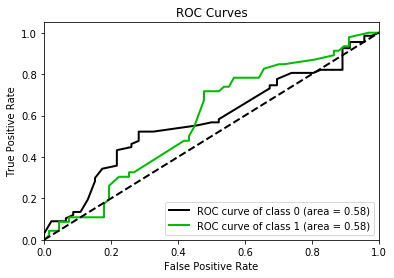

In [20]:
plot_roc(y_test, p_pred, plot_micro = False, plot_macro= False);

### LightGBM

In [21]:
import lightgbm as lgb
lg = lgb.LGBMClassifier()

In [22]:
rgrid = RandomizedSearchCV(estimator=lg, param_distributions=params, cv=kf, scoring='roc_auc',
                           n_iter=200, verbose=2, n_jobs=-1)

In [23]:
rgrid.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    5.9s finished
/anaconda3/envs/DataScience36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=779, shuffle=True),
          error_score='raise-deprecating',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid='warn', n_iter=200, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a251f1860>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2522fe48>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2522ff60>, 'colsample_bytree': <sc...2523bcf8>, 'min_child_weight': <scipy.stats._distn_infrastructur

In [24]:
best_lg = rgrid.best_estimator_
rgrid.best_params_

{'colsample_bytree': 0.9234857198570703,
 'gamma': 7.354637409904275,
 'learning_rate': 0.3367665883990071,
 'max_depth': 26,
 'min_child_weight': 10.813370009496335,
 'n_estimators': 172,
 'reg_alpha': 0.2723914256629422,
 'subsample': 0.9630019163952915}

In [25]:
p_pred = rgrid.predict_proba(X_test)

In [26]:
lg_score = roc_auc_score(y_score=p_pred[:, 1], y_true=y_test)

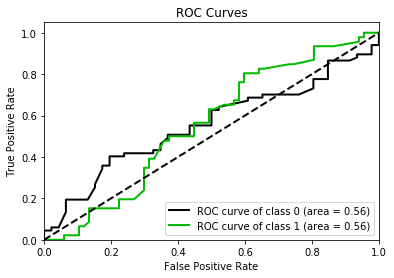

In [27]:
plot_roc(y_test, p_pred, plot_micro = False, plot_macro= False);

### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
params = {  
    "penalty"     : ['l1', 'l2'],
    "C"           : st.uniform(0.1, 10.),
}

In [29]:
rgrid = RandomizedSearchCV(estimator=log, param_distributions=params, cv=kf, scoring='roc_auc',
                           n_iter=100, verbose=2, n_jobs=-1)

In [30]:
rgrid.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
/anaconda3/envs/DataScience36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=779, shuffle=True),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a25826ac8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [31]:
best_log = rgrid.best_estimator_
rgrid.best_params_

{'C': 0.2591393361742266, 'penalty': 'l1'}

In [32]:
p_pred = rgrid.predict_proba(X_test)

In [33]:
log_score = roc_auc_score(y_score=p_pred[:, 1], y_true=y_test)

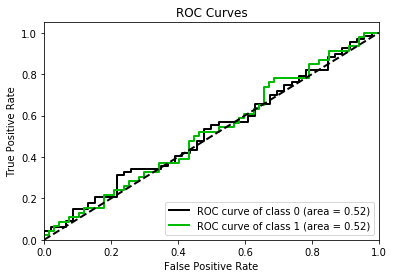

In [34]:
plot_roc(y_test, p_pred, plot_micro = False, plot_macro= False);

### CatBoost

In [35]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()

In [36]:
cat.fit(X, y)

0:	learn: 0.6920150	total: 61.9ms	remaining: 1m 1s
1:	learn: 0.6909081	total: 69.8ms	remaining: 34.8s
2:	learn: 0.6898291	total: 76.4ms	remaining: 25.4s
3:	learn: 0.6883295	total: 82.7ms	remaining: 20.6s
4:	learn: 0.6868191	total: 88.7ms	remaining: 17.7s
5:	learn: 0.6853594	total: 95.1ms	remaining: 15.8s
6:	learn: 0.6846507	total: 102ms	remaining: 14.4s
7:	learn: 0.6837082	total: 108ms	remaining: 13.3s
8:	learn: 0.6826287	total: 114ms	remaining: 12.5s
9:	learn: 0.6814071	total: 120ms	remaining: 11.9s
10:	learn: 0.6805720	total: 125ms	remaining: 11.3s
11:	learn: 0.6799923	total: 131ms	remaining: 10.8s
12:	learn: 0.6785391	total: 138ms	remaining: 10.5s
13:	learn: 0.6772659	total: 144ms	remaining: 10.2s
14:	learn: 0.6759557	total: 150ms	remaining: 9.88s
15:	learn: 0.6751583	total: 156ms	remaining: 9.62s
16:	learn: 0.6743693	total: 162ms	remaining: 9.38s
17:	learn: 0.6736850	total: 167ms	remaining: 9.13s
18:	learn: 0.6727311	total: 174ms	remaining: 8.96s
19:	learn: 0.6710492	total: 179ms	r

183:	learn: 0.5789475	total: 1.48s	remaining: 6.58s
184:	learn: 0.5786696	total: 1.5s	remaining: 6.6s
185:	learn: 0.5783903	total: 1.51s	remaining: 6.62s
186:	learn: 0.5778626	total: 1.52s	remaining: 6.61s
187:	learn: 0.5776620	total: 1.53s	remaining: 6.6s
188:	learn: 0.5774645	total: 1.53s	remaining: 6.58s
189:	learn: 0.5768482	total: 1.54s	remaining: 6.57s
190:	learn: 0.5767582	total: 1.54s	remaining: 6.54s
191:	learn: 0.5765126	total: 1.55s	remaining: 6.53s
192:	learn: 0.5757862	total: 1.56s	remaining: 6.51s
193:	learn: 0.5753877	total: 1.56s	remaining: 6.49s
194:	learn: 0.5751352	total: 1.57s	remaining: 6.47s
195:	learn: 0.5750238	total: 1.57s	remaining: 6.46s
196:	learn: 0.5747420	total: 1.58s	remaining: 6.44s
197:	learn: 0.5746839	total: 1.58s	remaining: 6.42s
198:	learn: 0.5741415	total: 1.59s	remaining: 6.4s
199:	learn: 0.5739317	total: 1.6s	remaining: 6.39s
200:	learn: 0.5736764	total: 1.6s	remaining: 6.37s
201:	learn: 0.5732406	total: 1.61s	remaining: 6.35s
202:	learn: 0.5730

366:	learn: 0.5279383	total: 2.68s	remaining: 4.63s
367:	learn: 0.5277583	total: 2.7s	remaining: 4.63s
368:	learn: 0.5277094	total: 2.71s	remaining: 4.63s
369:	learn: 0.5275711	total: 2.72s	remaining: 4.63s
370:	learn: 0.5272798	total: 2.72s	remaining: 4.62s
371:	learn: 0.5271115	total: 2.73s	remaining: 4.62s
372:	learn: 0.5269261	total: 2.75s	remaining: 4.61s
373:	learn: 0.5266330	total: 2.75s	remaining: 4.6s
374:	learn: 0.5264524	total: 2.76s	remaining: 4.59s
375:	learn: 0.5263769	total: 2.76s	remaining: 4.58s
376:	learn: 0.5262272	total: 2.77s	remaining: 4.57s
377:	learn: 0.5259035	total: 2.77s	remaining: 4.56s
378:	learn: 0.5258935	total: 2.78s	remaining: 4.55s
379:	learn: 0.5255550	total: 2.78s	remaining: 4.54s
380:	learn: 0.5254521	total: 2.79s	remaining: 4.53s
381:	learn: 0.5253171	total: 2.8s	remaining: 4.52s
382:	learn: 0.5250182	total: 2.8s	remaining: 4.51s
383:	learn: 0.5249289	total: 2.81s	remaining: 4.5s
384:	learn: 0.5245649	total: 2.81s	remaining: 4.49s
385:	learn: 0.524

551:	learn: 0.4927583	total: 3.88s	remaining: 3.15s
552:	learn: 0.4926676	total: 3.89s	remaining: 3.15s
553:	learn: 0.4924512	total: 3.91s	remaining: 3.14s
554:	learn: 0.4923917	total: 3.91s	remaining: 3.14s
555:	learn: 0.4923186	total: 3.92s	remaining: 3.13s
556:	learn: 0.4919929	total: 3.92s	remaining: 3.12s
557:	learn: 0.4918715	total: 3.93s	remaining: 3.11s
558:	learn: 0.4917690	total: 3.94s	remaining: 3.1s
559:	learn: 0.4915701	total: 3.94s	remaining: 3.1s
560:	learn: 0.4909470	total: 3.95s	remaining: 3.09s
561:	learn: 0.4909240	total: 3.95s	remaining: 3.08s
562:	learn: 0.4907845	total: 3.96s	remaining: 3.07s
563:	learn: 0.4907274	total: 3.96s	remaining: 3.06s
564:	learn: 0.4905267	total: 3.97s	remaining: 3.06s
565:	learn: 0.4904265	total: 3.98s	remaining: 3.05s
566:	learn: 0.4903303	total: 3.98s	remaining: 3.04s
567:	learn: 0.4900822	total: 3.99s	remaining: 3.03s
568:	learn: 0.4898632	total: 4s	remaining: 3.03s
569:	learn: 0.4897571	total: 4s	remaining: 3.02s
570:	learn: 0.489449

723:	learn: 0.4592448	total: 5.04s	remaining: 1.92s
724:	learn: 0.4591651	total: 5.05s	remaining: 1.92s
725:	learn: 0.4590003	total: 5.07s	remaining: 1.91s
726:	learn: 0.4583985	total: 5.07s	remaining: 1.9s
727:	learn: 0.4583795	total: 5.08s	remaining: 1.9s
728:	learn: 0.4582204	total: 5.08s	remaining: 1.89s
729:	learn: 0.4578837	total: 5.09s	remaining: 1.88s
730:	learn: 0.4578688	total: 5.09s	remaining: 1.87s
731:	learn: 0.4577976	total: 5.1s	remaining: 1.87s
732:	learn: 0.4575290	total: 5.11s	remaining: 1.86s
733:	learn: 0.4572943	total: 5.11s	remaining: 1.85s
734:	learn: 0.4569837	total: 5.12s	remaining: 1.84s
735:	learn: 0.4568300	total: 5.12s	remaining: 1.84s
736:	learn: 0.4564156	total: 5.13s	remaining: 1.83s
737:	learn: 0.4562750	total: 5.13s	remaining: 1.82s
738:	learn: 0.4560963	total: 5.14s	remaining: 1.81s
739:	learn: 0.4559983	total: 5.15s	remaining: 1.81s
740:	learn: 0.4559091	total: 5.15s	remaining: 1.8s
741:	learn: 0.4557681	total: 5.16s	remaining: 1.79s
742:	learn: 0.45

901:	learn: 0.4261515	total: 6.21s	remaining: 675ms
902:	learn: 0.4261149	total: 6.23s	remaining: 669ms
903:	learn: 0.4260740	total: 6.24s	remaining: 662ms
904:	learn: 0.4260519	total: 6.24s	remaining: 656ms
905:	learn: 0.4259235	total: 6.25s	remaining: 649ms
906:	learn: 0.4258771	total: 6.26s	remaining: 642ms
907:	learn: 0.4256676	total: 6.26s	remaining: 635ms
908:	learn: 0.4255995	total: 6.27s	remaining: 628ms
909:	learn: 0.4254783	total: 6.28s	remaining: 621ms
910:	learn: 0.4254401	total: 6.3s	remaining: 615ms
911:	learn: 0.4252483	total: 6.3s	remaining: 608ms
912:	learn: 0.4249261	total: 6.31s	remaining: 601ms
913:	learn: 0.4242439	total: 6.32s	remaining: 594ms
914:	learn: 0.4240051	total: 6.32s	remaining: 587ms
915:	learn: 0.4236117	total: 6.33s	remaining: 580ms
916:	learn: 0.4235298	total: 6.33s	remaining: 573ms
917:	learn: 0.4234499	total: 6.34s	remaining: 566ms
918:	learn: 0.4233615	total: 6.34s	remaining: 559ms
919:	learn: 0.4231752	total: 6.35s	remaining: 552ms
920:	learn: 0.

In [37]:
p_pred = cat.predict_proba(X_test)

In [38]:
cat_score = roc_auc_score(y_score=p_pred[:, 1], y_true=y_test)

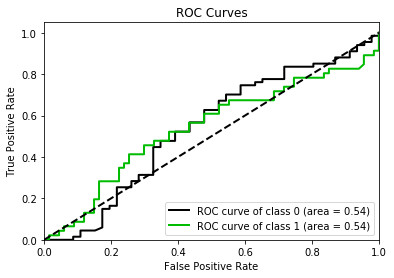

In [39]:
plot_roc(y_test, p_pred, plot_micro = False, plot_macro= False);

### Resultados

In [40]:
model_score = [rf_score, xg_score, lg_score, log_score, cat_score]
model_name = ['Random Forest', 'XGBoost', 'LightGBM', 'Logistic Regression', 'Catboost']
for score, name in zip(model_score, model_name):
    print('{:30}: {:.2f}'.format(name, score))

Random Forest                 : 0.50
XGBoost                       : 0.58
LightGBM                      : 0.56
Logistic Regression           : 0.52
Catboost                      : 0.54
